# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [1]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.binary_crossentropy(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

NameError: name 'tf' is not defined

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 253.5410 - y1_output_loss: 117.8365 - y2_output_loss: 133.7981 - y1_output_root_mean_squared_error: 10.8893 - y2_output_root_mean_squared_error: 11.6174 - val_loss: 47.8529 - val_y1_output_loss: 24.2896 - val_y2_output_loss: 24.4113 - val_y1_output_root_mean_squared_error: 4.8754 - val_y2_output_root_mean_squared_error: 4.9075
Epoch 2/500
614/614 [==============================] - 0s 195us/sample - loss: 40.8186 - y1_output_loss: 14.4897 - y2_output_loss: 26.1876 - y1_output_root_mean_squared_error: 3.8020 - y2_output_root_mean_squared_error: 5.1345 - val_loss: 22.5787 - val_y1_output_loss: 9.3696 - val_y2_output_loss: 12.8024 - val_y1_output_root_mean_squared_error: 3.0879 - val_y2_output_root_mean_squared_error: 3.6116
Epoch 3/500
614/614 [==============================] - 0s 180us/sample - loss: 29.0992 - y1_output_loss: 11.1563 - y2_output_loss: 17.9751 - y1_ou

614/614 [==============================] - 0s 145us/sample - loss: 7.7410 - y1_output_loss: 2.3909 - y2_output_loss: 5.3909 - y1_output_root_mean_squared_error: 1.5442 - y2_output_root_mean_squared_error: 2.3144 - val_loss: 6.5067 - val_y1_output_loss: 2.3926 - val_y2_output_loss: 4.1068 - val_y1_output_root_mean_squared_error: 1.5457 - val_y2_output_root_mean_squared_error: 2.0292
Epoch 42/500
614/614 [==============================] - 0s 162us/sample - loss: 9.9920 - y1_output_loss: 2.9549 - y2_output_loss: 7.0067 - y1_output_root_mean_squared_error: 1.7209 - y2_output_root_mean_squared_error: 2.6515 - val_loss: 6.1629 - val_y1_output_loss: 1.7221 - val_y2_output_loss: 4.3555 - val_y1_output_root_mean_squared_error: 1.3239 - val_y2_output_root_mean_squared_error: 2.1001
Epoch 43/500
614/614 [==============================] - 0s 171us/sample - loss: 7.6635 - y1_output_loss: 2.5175 - y2_output_loss: 5.1624 - y1_output_root_mean_squared_error: 1.5774 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 159us/sample - loss: 5.8088 - y1_output_loss: 1.7659 - y2_output_loss: 4.2361 - y1_output_root_mean_squared_error: 1.3114 - y2_output_root_mean_squared_error: 2.0221 - val_loss: 30.9825 - val_y1_output_loss: 8.9772 - val_y2_output_loss: 21.7270 - val_y1_output_root_mean_squared_error: 3.0091 - val_y2_output_root_mean_squared_error: 4.6827
Epoch 63/500
614/614 [==============================] - 0s 143us/sample - loss: 9.7929 - y1_output_loss: 3.1275 - y2_output_loss: 6.5925 - y1_output_root_mean_squared_error: 1.7729 - y2_output_root_mean_squared_error: 2.5787 - val_loss: 4.5433 - val_y1_output_loss: 1.4158 - val_y2_output_loss: 3.0737 - val_y1_output_root_mean_squared_error: 1.1950 - val_y2_output_root_mean_squared_error: 1.7650
Epoch 64/500
614/614 [==============================] - 0s 159us/sample - loss: 9.5952 - y1_output_loss: 3.1474 - y2_output_loss: 6.3601 - y1_output_root_mean_squared_error: 1.7815 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 166us/sample - loss: 4.2580 - y1_output_loss: 1.0723 - y2_output_loss: 3.1574 - y1_output_root_mean_squared_error: 1.0386 - y2_output_root_mean_squared_error: 1.7831 - val_loss: 5.3841 - val_y1_output_loss: 1.3730 - val_y2_output_loss: 3.8124 - val_y1_output_root_mean_squared_error: 1.1937 - val_y2_output_root_mean_squared_error: 1.9898
Epoch 84/500
614/614 [==============================] - 0s 145us/sample - loss: 6.1249 - y1_output_loss: 1.4336 - y2_output_loss: 4.6504 - y1_output_root_mean_squared_error: 1.2004 - y2_output_root_mean_squared_error: 2.1642 - val_loss: 2.6729 - val_y1_output_loss: 0.6181 - val_y2_output_loss: 1.9976 - val_y1_output_root_mean_squared_error: 0.7971 - val_y2_output_root_mean_squared_error: 1.4274
Epoch 85/500
614/614 [==============================] - 0s 145us/sample - loss: 2.9613 - y1_output_loss: 0.7375 - y2_output_loss: 2.2321 - y1_output_root_mean_squared_error: 0.8583 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 167us/sample - loss: 2.7633 - y1_output_loss: 0.7576 - y2_output_loss: 2.0095 - y1_output_root_mean_squared_error: 0.8706 - y2_output_root_mean_squared_error: 1.4161 - val_loss: 4.7378 - val_y1_output_loss: 0.7808 - val_y2_output_loss: 3.9006 - val_y1_output_root_mean_squared_error: 0.8941 - val_y2_output_root_mean_squared_error: 1.9845
Epoch 105/500
614/614 [==============================] - 0s 141us/sample - loss: 2.4546 - y1_output_loss: 0.6701 - y2_output_loss: 1.7670 - y1_output_root_mean_squared_error: 0.8219 - y2_output_root_mean_squared_error: 1.3338 - val_loss: 2.8090 - val_y1_output_loss: 0.6776 - val_y2_output_loss: 2.0417 - val_y1_output_root_mean_squared_error: 0.8363 - val_y2_output_root_mean_squared_error: 1.4524
Epoch 106/500
614/614 [==============================] - 0s 168us/sample - loss: 3.8230 - y1_output_loss: 1.1588 - y2_output_loss: 2.6431 - y1_output_root_mean_squared_error: 1.0759 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 140us/sample - loss: 1.7443 - y1_output_loss: 0.4757 - y2_output_loss: 1.2840 - y1_output_root_mean_squared_error: 0.6912 - y2_output_root_mean_squared_error: 1.1254 - val_loss: 7.9531 - val_y1_output_loss: 0.6188 - val_y2_output_loss: 7.1602 - val_y1_output_root_mean_squared_error: 0.8002 - val_y2_output_root_mean_squared_error: 2.7042
Epoch 146/500
614/614 [==============================] - 0s 144us/sample - loss: 2.4163 - y1_output_loss: 0.5157 - y2_output_loss: 1.8887 - y1_output_root_mean_squared_error: 0.7214 - y2_output_root_mean_squared_error: 1.3769 - val_loss: 2.3637 - val_y1_output_loss: 0.5177 - val_y2_output_loss: 1.7739 - val_y1_output_root_mean_squared_error: 0.7319 - val_y2_output_root_mean_squared_error: 1.3521
Epoch 147/500
614/614 [==============================] - 0s 144us/sample - loss: 1.7762 - y1_output_loss: 0.4222 - y2_output_loss: 1.3435 - y1_output_root_mean_squared_error: 0.6506 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 161us/sample - loss: 1.4070 - y1_output_loss: 0.3340 - y2_output_loss: 1.0668 - y1_output_root_mean_squared_error: 0.5787 - y2_output_root_mean_squared_error: 1.0354 - val_loss: 1.2741 - val_y1_output_loss: 0.2472 - val_y2_output_loss: 0.9867 - val_y1_output_root_mean_squared_error: 0.5045 - val_y2_output_root_mean_squared_error: 1.0097
Epoch 187/500
614/614 [==============================] - 0s 168us/sample - loss: 1.3330 - y1_output_loss: 0.2876 - y2_output_loss: 1.0604 - y1_output_root_mean_squared_error: 0.5300 - y2_output_root_mean_squared_error: 1.0257 - val_loss: 4.0344 - val_y1_output_loss: 1.1980 - val_y2_output_loss: 2.7561 - val_y1_output_root_mean_squared_error: 1.0958 - val_y2_output_root_mean_squared_error: 1.6833
Epoch 188/500
614/614 [==============================] - 0s 164us/sample - loss: 1.5785 - y1_output_loss: 0.3973 - y2_output_loss: 1.1772 - y1_output_root_mean_squared_error: 0.6310 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 195us/sample - loss: 0.9599 - y1_output_loss: 0.2457 - y2_output_loss: 0.7453 - y1_output_root_mean_squared_error: 0.4934 - y2_output_root_mean_squared_error: 0.8464 - val_loss: 1.2971 - val_y1_output_loss: 0.2320 - val_y2_output_loss: 1.0250 - val_y1_output_root_mean_squared_error: 0.4905 - val_y2_output_root_mean_squared_error: 1.0278
Epoch 228/500
614/614 [==============================] - 0s 150us/sample - loss: 1.7246 - y1_output_loss: 0.4413 - y2_output_loss: 1.2694 - y1_output_root_mean_squared_error: 0.6670 - y2_output_root_mean_squared_error: 1.1313 - val_loss: 1.2186 - val_y1_output_loss: 0.1885 - val_y2_output_loss: 0.9924 - val_y1_output_root_mean_squared_error: 0.4414 - val_y2_output_root_mean_squared_error: 1.0118
Epoch 229/500
614/614 [==============================] - 0s 153us/sample - loss: 1.2251 - y1_output_loss: 0.2984 - y2_output_loss: 0.9155 - y1_output_root_mean_squared_error: 0.5489 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 146us/sample - loss: 0.8995 - y1_output_loss: 0.2286 - y2_output_loss: 0.6630 - y1_output_root_mean_squared_error: 0.4803 - y2_output_root_mean_squared_error: 0.8178 - val_loss: 0.9283 - val_y1_output_loss: 0.1596 - val_y2_output_loss: 0.7384 - val_y1_output_root_mean_squared_error: 0.4050 - val_y2_output_root_mean_squared_error: 0.8742
Epoch 269/500
614/614 [==============================] - 0s 143us/sample - loss: 0.8556 - y1_output_loss: 0.2155 - y2_output_loss: 0.6445 - y1_output_root_mean_squared_error: 0.4628 - y2_output_root_mean_squared_error: 0.8009 - val_loss: 1.8007 - val_y1_output_loss: 0.1636 - val_y2_output_loss: 1.5907 - val_y1_output_root_mean_squared_error: 0.4086 - val_y2_output_root_mean_squared_error: 1.2782
Epoch 270/500
614/614 [==============================] - 0s 191us/sample - loss: 1.2450 - y1_output_loss: 0.2280 - y2_output_loss: 1.0138 - y1_output_root_mean_squared_error: 0.4763 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 149us/sample - loss: 0.7261 - y1_output_loss: 0.1923 - y2_output_loss: 0.5311 - y1_output_root_mean_squared_error: 0.4392 - y2_output_root_mean_squared_error: 0.7302 - val_loss: 0.9797 - val_y1_output_loss: 0.2204 - val_y2_output_loss: 0.7294 - val_y1_output_root_mean_squared_error: 0.4772 - val_y2_output_root_mean_squared_error: 0.8672
Epoch 310/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6771 - y1_output_loss: 0.1737 - y2_output_loss: 0.4976 - y1_output_root_mean_squared_error: 0.4180 - y2_output_root_mean_squared_error: 0.7088 - val_loss: 0.8817 - val_y1_output_loss: 0.1703 - val_y2_output_loss: 0.6807 - val_y1_output_root_mean_squared_error: 0.4197 - val_y2_output_root_mean_squared_error: 0.8400
Epoch 311/500
614/614 [==============================] - 0s 166us/sample - loss: 0.6395 - y1_output_loss: 0.1578 - y2_output_loss: 0.4779 - y1_output_root_mean_squared_error: 0.3969 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 202us/sample - loss: 0.8710 - y1_output_loss: 0.2407 - y2_output_loss: 0.6263 - y1_output_root_mean_squared_error: 0.4895 - y2_output_root_mean_squared_error: 0.7946 - val_loss: 0.9109 - val_y1_output_loss: 0.1632 - val_y2_output_loss: 0.7187 - val_y1_output_root_mean_squared_error: 0.4104 - val_y2_output_root_mean_squared_error: 0.8617
Epoch 351/500
614/614 [==============================] - 0s 163us/sample - loss: 0.5836 - y1_output_loss: 0.1599 - y2_output_loss: 0.4239 - y1_output_root_mean_squared_error: 0.3965 - y2_output_root_mean_squared_error: 0.6529 - val_loss: 1.1224 - val_y1_output_loss: 0.2189 - val_y2_output_loss: 0.8726 - val_y1_output_root_mean_squared_error: 0.4726 - val_y2_output_root_mean_squared_error: 0.9482
Epoch 352/500
614/614 [==============================] - 0s 168us/sample - loss: 0.6426 - y1_output_loss: 0.1765 - y2_output_loss: 0.4698 - y1_output_root_mean_squared_error: 0.4203 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 177us/sample - loss: 0.5373 - y1_output_loss: 0.1478 - y2_output_loss: 0.3860 - y1_output_root_mean_squared_error: 0.3855 - y2_output_root_mean_squared_error: 0.6234 - val_loss: 0.8599 - val_y1_output_loss: 0.2061 - val_y2_output_loss: 0.6235 - val_y1_output_root_mean_squared_error: 0.4618 - val_y2_output_root_mean_squared_error: 0.8042
Epoch 392/500
614/614 [==============================] - 0s 172us/sample - loss: 0.4884 - y1_output_loss: 0.1374 - y2_output_loss: 0.3519 - y1_output_root_mean_squared_error: 0.3721 - y2_output_root_mean_squared_error: 0.5916 - val_loss: 0.8955 - val_y1_output_loss: 0.1301 - val_y2_output_loss: 0.7359 - val_y1_output_root_mean_squared_error: 0.3662 - val_y2_output_root_mean_squared_error: 0.8726
Epoch 393/500
614/614 [==============================] - 0s 165us/sample - loss: 0.5594 - y1_output_loss: 0.1514 - y2_output_loss: 0.4062 - y1_output_root_mean_squared_error: 0.3902 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 270us/sample - loss: 0.4394 - y1_output_loss: 0.1483 - y2_output_loss: 0.2950 - y1_output_root_mean_squared_error: 0.3860 - y2_output_root_mean_squared_error: 0.5388 - val_loss: 1.0971 - val_y1_output_loss: 0.1448 - val_y2_output_loss: 0.9230 - val_y1_output_root_mean_squared_error: 0.3865 - val_y2_output_root_mean_squared_error: 0.9735
Epoch 433/500
614/614 [==============================] - 0s 150us/sample - loss: 0.4874 - y1_output_loss: 0.1251 - y2_output_loss: 0.3645 - y1_output_root_mean_squared_error: 0.3522 - y2_output_root_mean_squared_error: 0.6028 - val_loss: 1.1560 - val_y1_output_loss: 0.3040 - val_y2_output_loss: 0.8182 - val_y1_output_root_mean_squared_error: 0.5564 - val_y2_output_root_mean_squared_error: 0.9200
Epoch 434/500
614/614 [==============================] - 0s 193us/sample - loss: 0.5368 - y1_output_loss: 0.1460 - y2_output_loss: 0.3889 - y1_output_root_mean_squared_error: 0.3818 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 155us/sample - loss: 0.3663 - y1_output_loss: 0.1258 - y2_output_loss: 0.2390 - y1_output_root_mean_squared_error: 0.3537 - y2_output_root_mean_squared_error: 0.4911 - val_loss: 0.7708 - val_y1_output_loss: 0.1458 - val_y2_output_loss: 0.6026 - val_y1_output_root_mean_squared_error: 0.3862 - val_y2_output_root_mean_squared_error: 0.7884
Epoch 474/500
614/614 [==============================] - 0s 163us/sample - loss: 0.3481 - y1_output_loss: 0.1134 - y2_output_loss: 0.2370 - y1_output_root_mean_squared_error: 0.3369 - y2_output_root_mean_squared_error: 0.4843 - val_loss: 1.2245 - val_y1_output_loss: 0.1376 - val_y2_output_loss: 1.0474 - val_y1_output_root_mean_squared_error: 0.3766 - val_y2_output_root_mean_squared_error: 1.0405
Epoch 475/500
614/614 [==============================] - 0s 169us/sample - loss: 0.3536 - y1_output_loss: 0.1176 - y2_output_loss: 0.2353 - y1_output_root_mean_squared_error: 0.3432 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 51us/sample - loss: 0.9759 - y1_output_loss: 0.1606 - y2_output_loss: 0.8188 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mean_squared_error: 0.9033
Loss = 0.9759031843829464, Y1_loss = 0.1606360673904419, Y1_mse = 0.39994803071022034, Y2_loss = 0.8188272714614868, Y2_mse = 0.9032966494560242


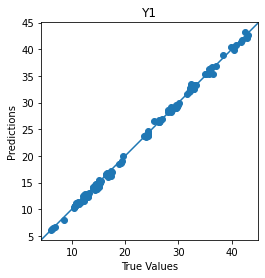

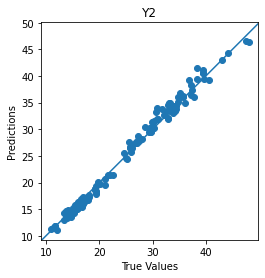

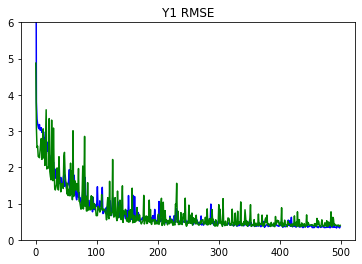

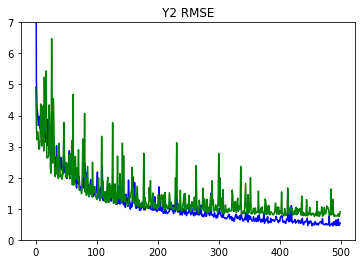

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)